***Work Flow***

**First Cut**
*clean data*
Knn and mice
knnChoice, explaination
Kept mice for further experimentation

**Second Cut**
*interpret and feature ranking*
Plug into maps, visual represenation 

identify relationships
por-perm linear
Pvel, youngs, connecte to density

Feature ranking
graphs, partil vs reg, correclation coeffient
lack of outlyers
choice and why
validate with voilen and random regression

options open for further experimentation

**Third Cut**
*prediction models*
linear vs knn vs prediction tree vs random forest
Testing with various input
calucation and evauation of accucry via 


**First Cut**

At a glance, Maps

Clean data.
Looking over various ways to clean data, aka fill in missing values so we can plug itto prediction models.
sled hammer approteces such as cut features with missing data, replacing with constants, cut all wells with missing data, introduces biasis or leaves us with little to no data. 

Instead Knn or Mice 
KNN: For each missing value, finds the k-nearest samples (rows) with similar feature values (using available features), then imputes the missing value as the average (or weighted average) of those neighbors.
Pros: Simple and intuitive.Captures local structure in the data.
Cons: Can be slow for large datasets.Sensitive to the choice of k. Does not model relationships between features as explicitly as MICE.
MICE:Iteratively models each feature with missing values as a function of other features, using regression. Each missing value is imputed multiple times in a round-robin fashion until convergence.
Pros: Handles multivariate relationships between features. Can provide multiple imputed datasets for uncertainty estimation.More flexible for complex data patterns.
Cons: More computationally intensive.Requires careful parameter tuning.Can be sensitive to model assumptions.

choice and Why, KNN- for simplicty, mice isnt strictly nessacry becasue the data is nice and pretty, uncomplex, and small. only 73. Mice risks complicating things when knn is quote "perfectly fine" (Dr. Pyre) 
However, did both for future experimetation 
Final files: knn ==[text](Pyrcz_ebook/dataframe_imputed.csv)
             mice == [text](Pyrcz_ebook/dataframeMC_imputed.csv)


In [53]:
# code credited to Dr. Pyres, modified to data set
ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
from sklearn.impute import SimpleImputer                      # basic imputation method
from sklearn.impute import KNNImputer                         # k-nearest neighbour imputation method
from sklearn.experimental import enable_iterative_imputer     # required for MICE imputation
from sklearn.impute import IterativeImputer                   # MICE imputation
import os                                                     # set working directory, run executables
import math                                                   # basic math operations
import random                                                 # for random numbers
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import matplotlib.ticker as mtick                             # control tick label formatting
import seaborn as sns                                         # for matrix scatter plots
from scipy import stats                                       # summary statistics
import numpy.linalg as linalg                                 # for linear algebra
import scipy.spatial as sp                                    # for fast nearest neighbor search
import scipy.signal as signal                                 # kernel for moving window calculation
from numba import jit                                         # for numerical speed up
from statsmodels.stats.weightstats import DescrStatsW
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map
seed = 73071                                                  # random seed
np.random.seed(seed=seed)

In [54]:
def add_grid():                                               # add major and minor gridlines
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

In [55]:
# code credited to Dr. Pyres, modified to data set
idata = 2

if idata == 0:
    df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v4.csv') # load data from Dr. Pyrcz's GitHub repository  
    df.drop('Prod',axis=1,inplace=True)

    features = df.columns.values.tolist()                          # store the names of the features
    
    xmin = [6.0,0.0,1.0,10.0,0.0,0.9]; xmax = [24.0,10.0,5.0,85.0,2.2,2.9] # set the minimum and maximum values for plotting

    flabel = ['Porosity (%)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Brittleness Ratio (%)', # set the names for plotting
             'Total Organic Carbon (%)','Vitrinite Reflectance (%)']

    ftitle = ['Porosity','Permeability','Acoustic Impedance','Brittleness Ratio', # set the units for plotting
             'Total Organic Carbon','Vitrinite Reflectance']

elif idata == 1:
    names = {'Porosity':'Por'}
    
    df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/12_sample_data.csv') # load data from Dr. Pyrcz's GitHub repository  
    df = df.rename(columns=names)
    df['Por'] = df['Por'] * 100.0; df['AI'] = df['AI'] / 1000.0; 
    df.drop('Unnamed: 0',axis=1,inplace=True) 
    
    features = df.columns.values.tolist()                          # store the names of the features

    xmin = [0.0,0.0,0.0,4.0,0.0,6.5,1.4,1600.0,10.0,1300.0,1.6]; xmax = [10000.0,10000.0,1.0,19.0,500.0,8.3,3.6,6200.0,50.0,2000.0,12.0] # set the minimum and maximum values for plotting
    
    flabel = ['Well (ID)','X (m)','Y (m)','Depth (m)','Porosity (fraction)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Facies (categorical)',
              'Density (g/cm^3)','Compressible velocity (m/s)','Youngs modulus (GPa)', 'Shear velocity (m/s)', 'Shear modulus (GPa)'] # set the names for plotting

    ftitle = ['Well','X','Y','Depth','Porosity','Permeability','Acoustic Impedance','Facies',
              'Density','Compressible velocity','Youngs modulus', 'Shear velocity', 'Shear modulus']

elif idata == 2:  
    df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/res21_2D_wells.csv') # load data from Dr. Pyrcz's GitHub repository  
    
    features = df.columns.values.tolist()                          # store the names of the features

    xmin = [1,0.0,0.0,4.0,0.0,6.5,1.4,1600.0,10.0,1300.0,1.6]; xmax = [73,10000.0,10000.0,19.0,500.0,8.3,3.6,6200.0,50.0,2000.0,12.0] # set the minimum and maximum values for plotting
    
    flabel = ['Well (ID)','X (m)','Y (m)','Depth (m)','Porosity (fraction)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Facies (categorical)',
              'Density (g/cm^3)','Compressible velocity (m/s)','Youngs modulus (GPa)', 'Shear velocity (m/s)', 'Shear modulus (GPa)'] # set the names for plotting

    ftitle = ['Well','X','Y','Depth','Porosity','Permeability','Acoustic Impedance','Facies',
              'Density','Compressible velocity','Youngs modulus', 'Shear velocity', 'Shear modulus']

In [56]:
# code credited to Dr. Pyres, modified to data set
if idata == 0 or idata == 1:
    proportion_NaN = 0.1                                          # proportion of values in DataFrame to remove
    np.random.seed(seed=seed)                                     # ensure repeatability
    remove = np.random.random(df.shape) < proportion_NaN          # make the boolean array for removal
    if idata == 1:
        remove[:,df.columns.get_loc('Facies')] = False            # avoid categoical imputation at this time          
    print('Fraction of removed values in mask ndarray = ' + str(round(remove.sum()/remove.size,3)) + '.')

    df_mask = df.mask(remove)
else:
    df_mask = df.copy(deep = True)

print('Fraction of nan values in the DataFrame = ' + str(round(df_mask.isnull().sum().sum()/(df_mask.shape[0]*df_mask.shape[1]),3)) + '.')

Fraction of nan values in the DataFrame = 0.105.


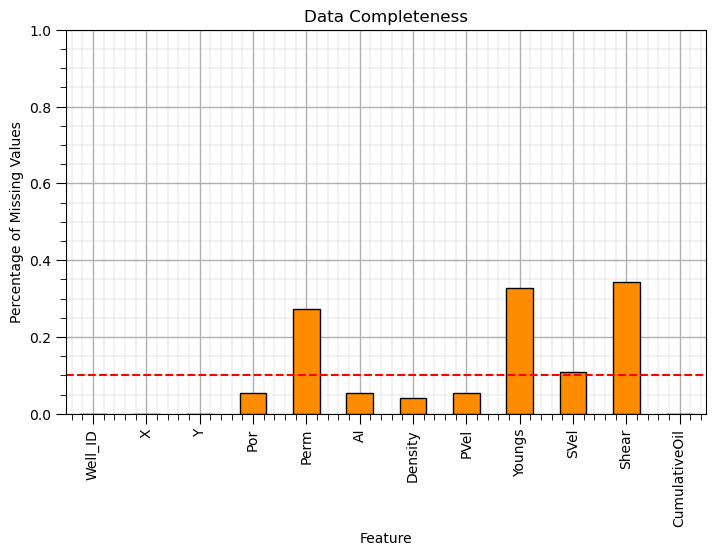

In [57]:
# code credited to Dr. Pyres, modified to data set
df_mask.head(n=13)   
df_mask.describe().transpose() 
plt.subplot(111)                                              # data completeness plot
(df_mask.isnull().sum()/len(df)).plot(kind = 'bar',color='darkorange',edgecolor='black') 
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness'); plt.ylim([0.0,1.0])
plt.plot([-0.5,df.shape[1]+0.5],[0.1,0.1],color='red',ls='--')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.8, wspace=0.2, hspace=0.2); add_grid(); plt.show()

Well_ID       X       Y        Por        Perm        AI   Density  \
0        1  7325.0  7175.0  13.564033         NaN  7.214987  2.153530   
1        2  4225.0  3525.0  12.907730  133.910637  7.308846  2.146360   
2        3  7725.0  8275.0  12.110566  104.059282  7.366451  1.919698   
3        4  4425.0  6475.0  13.990654  139.915993  7.286771  1.980721   
4        5  2125.0  1225.0  12.982720         NaN  7.333877  1.928716   

          PVel     Youngs         SVel     Shear  CumulativeOil  Imputed  
0  3379.255305  25.875998  1658.612455       NaN         847.33     True  
1  3563.549461  25.688560  1673.770439  6.429229        1201.20    False  
2  3882.442911        NaN  1675.645601  5.674798         781.40     True  
3  3688.351168  27.125611          NaN  5.408664        1573.20     True  
4  3777.566423  28.133694          NaN  5.265054         548.68     True

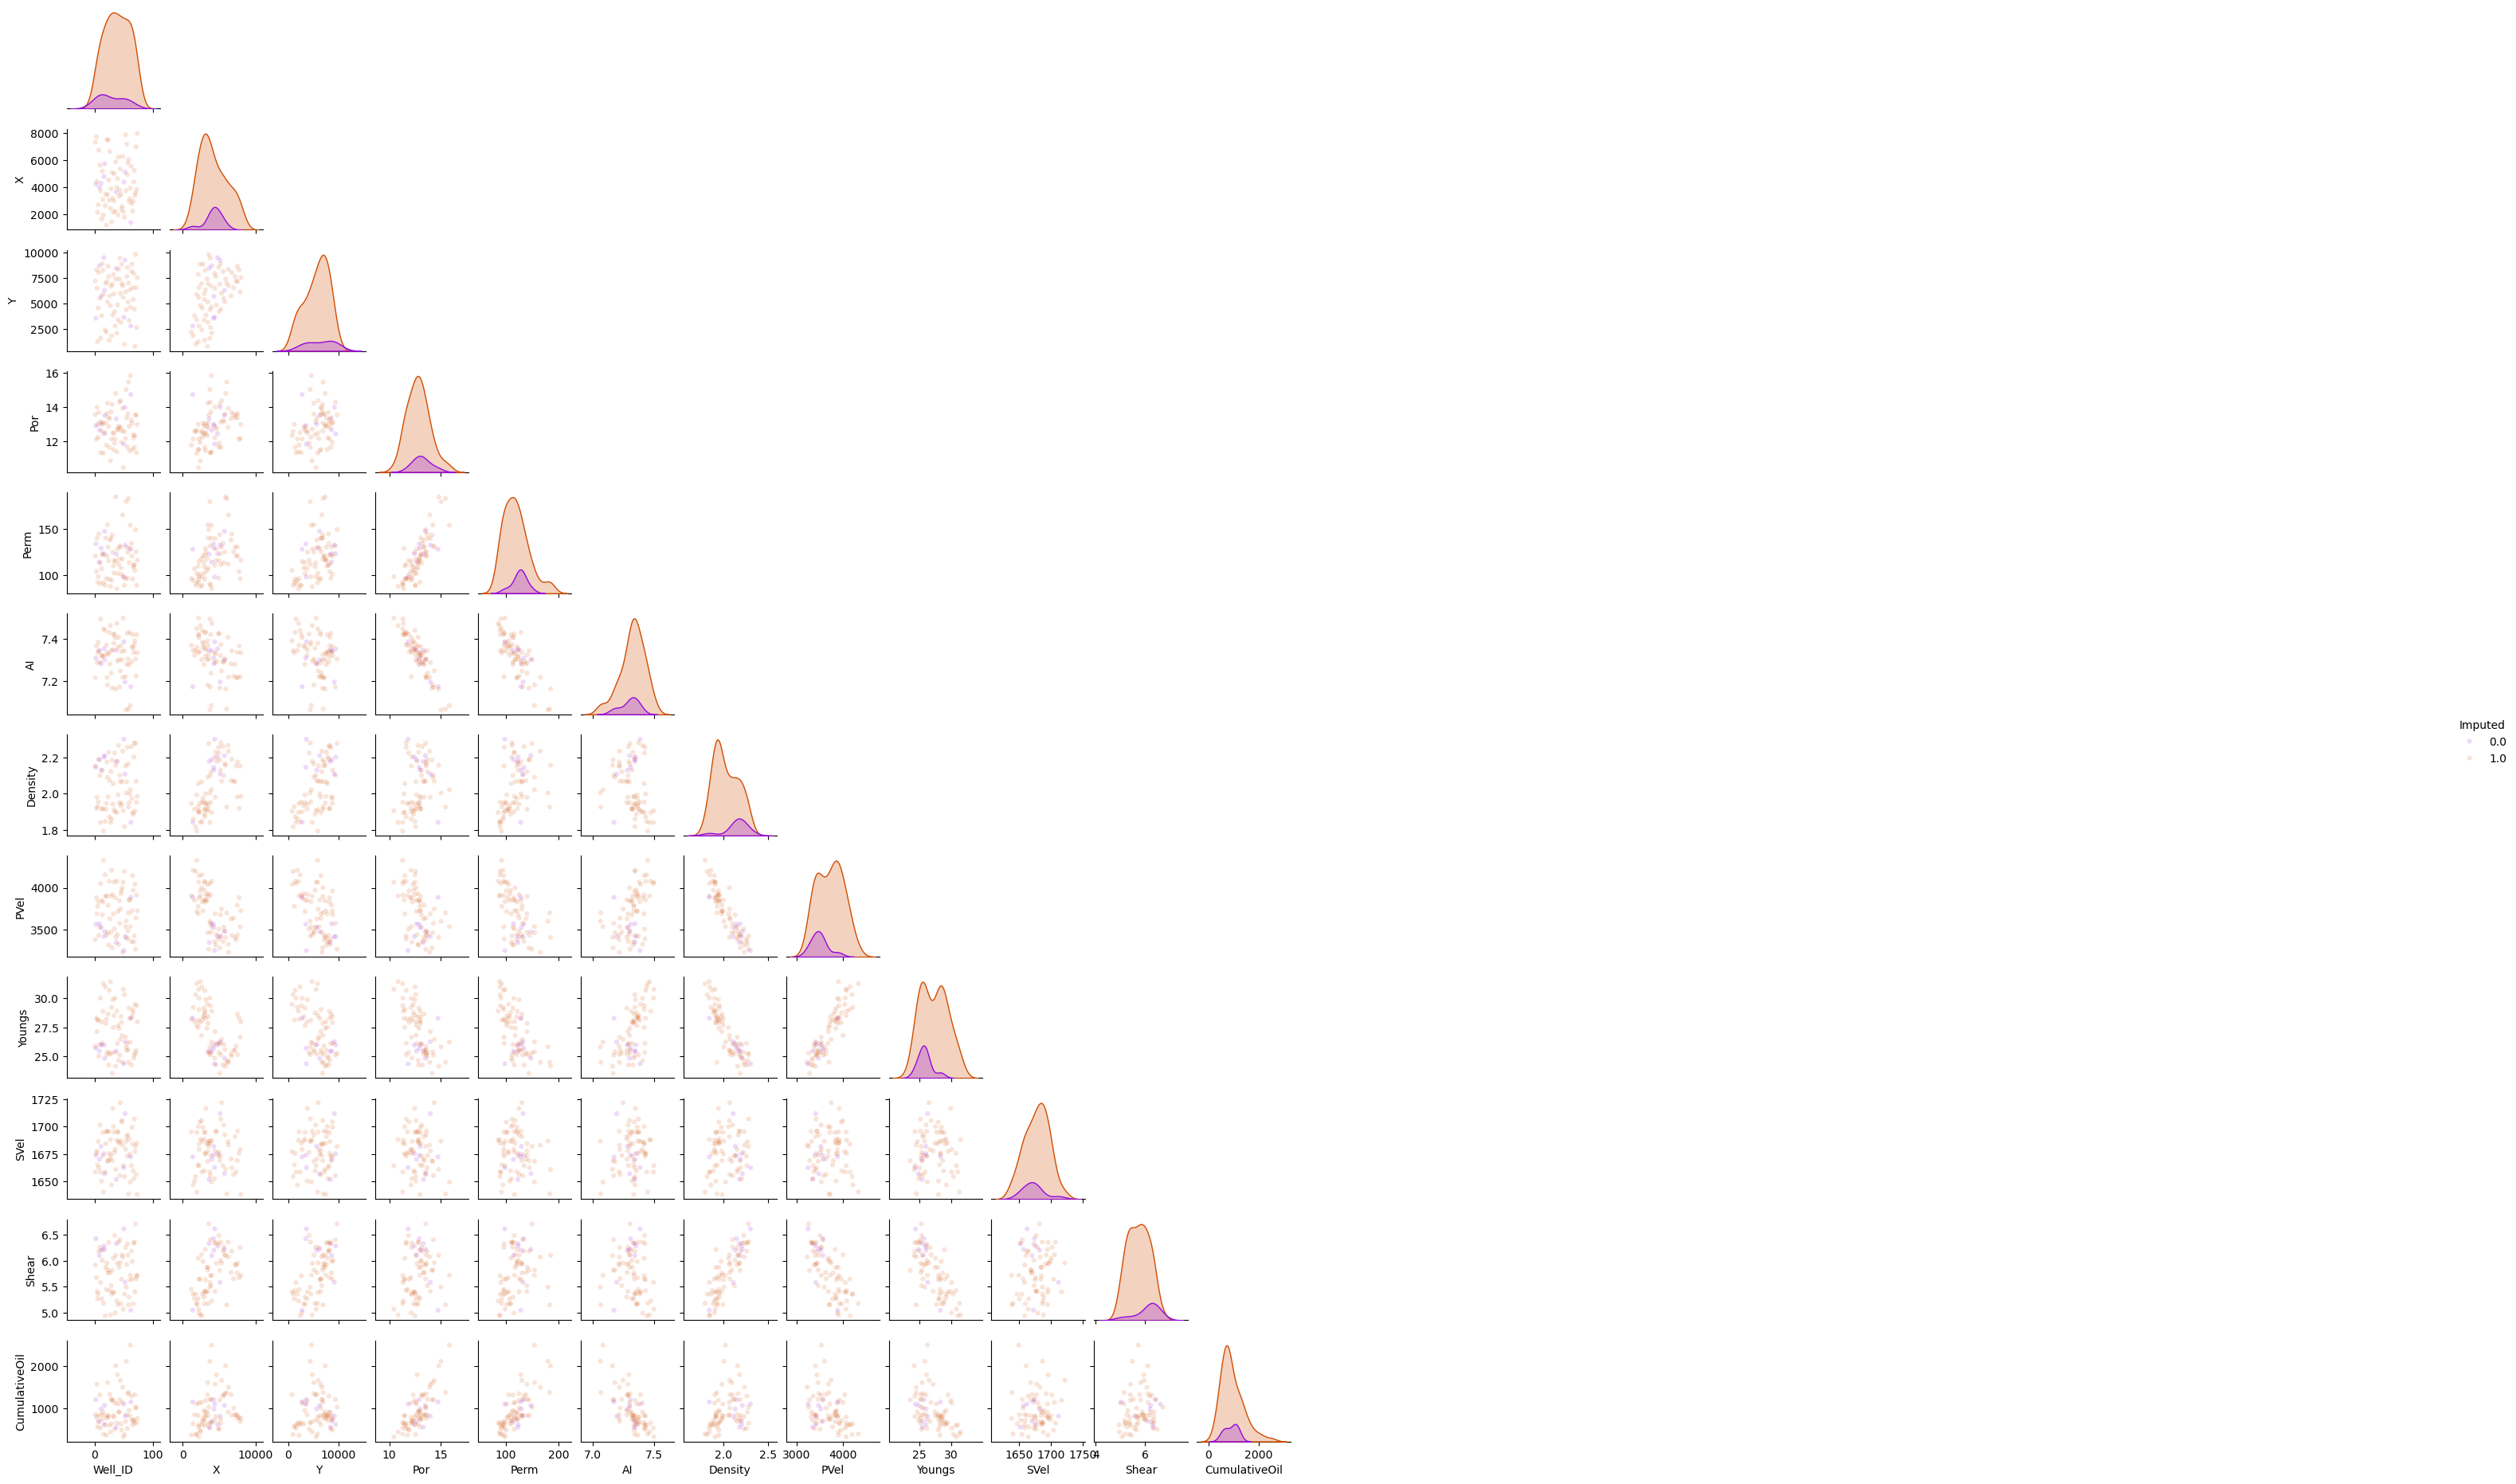

In [58]:
df_mask['Imputed'] = (df_mask.isnull().sum(axis=1)) > 0
df_mask.head()

df_knn = df_mask.copy(deep=True)                         # make a deep copy of the DataFrame
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_knn.iloc[:,:] = knn_imputer.fit_transform(df_knn)

sns.pairplot(df_knn.iloc[:,:], hue="Imputed", plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)
df_constant = df_mask.copy(deep=True) 
df_mode = df_mask.copy(deep=True)  
df_constant.head(n=5)
df_mode.head(n=5)

Well_ID       X       Y        Por        Perm        AI   Density  \
0        1  7325.0  7175.0  13.564033         NaN  7.214987  2.153530   
1        2  4225.0  3525.0  12.907730  133.910637  7.308846  2.146360   
2        3  7725.0  8275.0  12.110566  104.059282  7.366451  1.919698   
3        4  4425.0  6475.0  13.990654  139.915993  7.286771  1.980721   
4        5  2125.0  1225.0  12.982720         NaN  7.333877  1.928716   

          PVel     Youngs         SVel     Shear  CumulativeOil  Imputed  
0  3379.255305  25.875998  1658.612455       NaN         847.33     True  
1  3563.549461  25.688560  1673.770439  6.429229        1201.20    False  
2  3882.442911        NaN  1675.645601  5.674798         781.40     True  
3  3688.351168  27.125611          NaN  5.408664        1573.20     True  
4  3777.566423  28.133694          NaN  5.265054         548.68     True

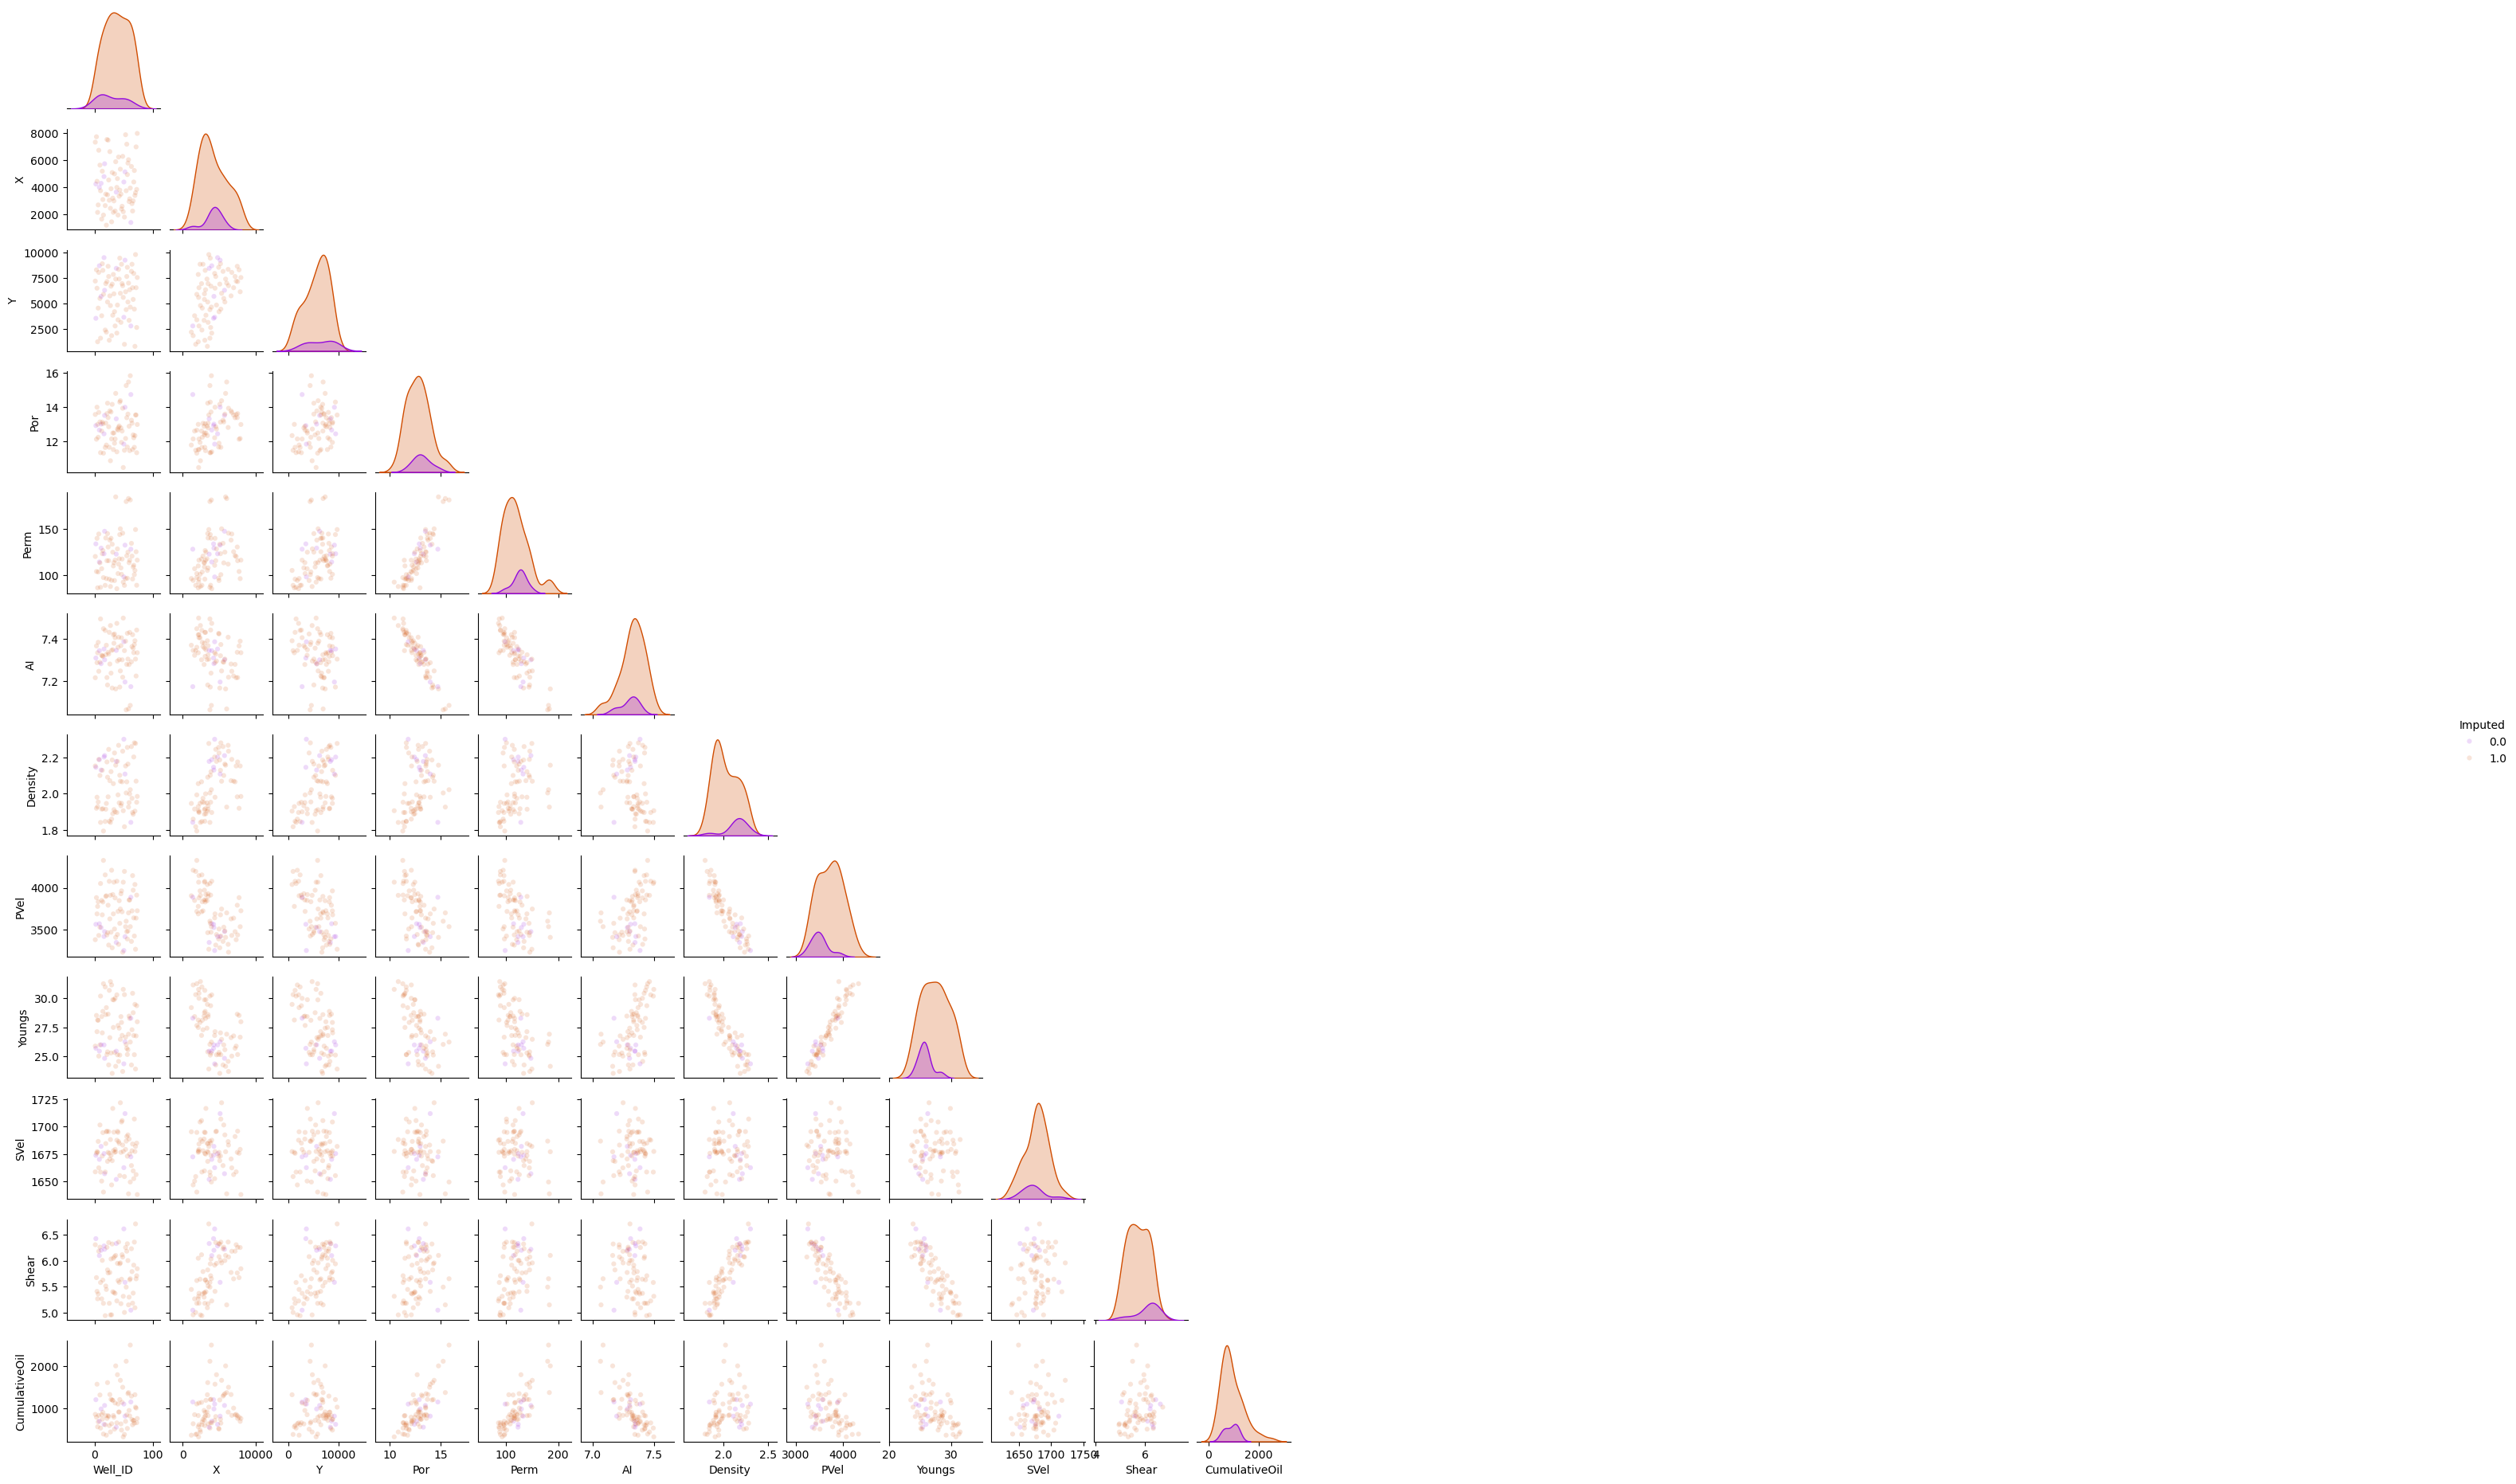

In [59]:
df_mice = df_mask.copy(deep=True)                         # make a deep copy of the DataFrame
mice_imputer = IterativeImputer()
df_mice.iloc[:,:] = mice_imputer.fit_transform(df_mice)

sns.pairplot(df_mice.iloc[:,:], hue="Imputed", plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)
df_constant.head(n=5)
df_mode.head(n=5)

**Second Cut**

*Interpret data*
looking for data with simliar trends, high correlation, so we can cut those features in final predictions. The more features put in, the higher deminaity, and higher chance of it all turning into mush so we only put in the most important info with an effect. 
"C:\Users\alice\OneDrive\Pictures\Screenshots\Screenshot 2025-06-25 103902.png" 
Porsity x axis, permability y axis, direct correlation, we prob only need 1
"C:\Users\alice\OneDrive\Pictures\Screenshots\Screenshot 2025-06-25 104131.png"
Pvel x axis, Youngs y axis, direct correlation we prob only need 1
Another intresting find, Pvel and young both had strong inverse relationship with density

Expert Knowlege 

4. Porosity (fraction or %)
The fraction (or percentage) of the rock volume that consists of pore spaces, indicating the capacity of the rock to hold fluids (oil, gas, water).
5. Permeability (mD)
The ability of the rock to transmit fluids, measured in millidarcies (mD). Higher values mean fluids can flow more easily through the rock.
(makes sense why pores and permeabilty are related, but transmit fluid might be more important )
12. Compressional Velocity (m/s)
The speed at which compressional (P) seismic waves travel through the rock, measured in meters per second.

13. Young’s Modulus (GPa)
A measure of the rock’s stiffness, indicating how much it will deform under stress, measured in gigapascals.



Feature Ranking 


In [60]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python  
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.72


In [61]:
ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
from sklearn import preprocessing                             # remove encoding error
from sklearn.feature_selection import RFE                     # for recursive feature selection
from sklearn.feature_selection import mutual_info_regression  # mutual information
from sklearn.linear_model import LinearRegression             # linear regression model
from sklearn.ensemble import RandomForestRegressor            # model-based feature importance
from sklearn import metrics                                   # measures to check our models
from statsmodels.stats.outliers_influence import variance_inflation_factor # variance inflation factor
import os                                                     # set working directory, run executables
import math                                                   # basic math operations
import random                                                 # for random numbers
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import matplotlib.ticker as mtick                             # control tick label formatting
import seaborn as sns                                         # for matrix scatter plots
from scipy import stats                                       # summary statistics
import numpy.linalg as linalg                                 # for linear algebra
import scipy.spatial as sp                                    # for fast nearest neighbor search
import scipy.signal as signal                                 # kernel for moving window calculation
from numba import jit                                         # for numerical speed up
from statsmodels.stats.weightstats import DescrStatsW
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map
import sys
#!{sys.executable} -m pip install shap
import shap
shap.initjs()

In [62]:
my_colormap = plt.cm.get_cmap('RdBu_r', 256)                  # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))               # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])              # define white color (4 channel)
#newcolors[26:230, :] = white                                 # mask all correlations less than abs(0.8)
#newcolors[56:200, :] = white                                 # mask all correlations less than abs(0.6)
newcolors[76:180, :] = white                                  # mask all correlations less than abs(0.4)
signif = ListedColormap(newcolors)                            # assign as listed colormap
         
my_colormap = plt.cm.get_cmap('inferno', 256)                 # make a custom colormap
newcolors = my_colormap(np.linspace(0, 1, 256))               # define colormap space
white = np.array([250/256, 250/256, 250/256, 1])              # define white color (4 channel)
#newcolors[26:230, :] = white                                 # mask all correlations less than abs(0.8)
newcolors[0:12, :] = white                                    # mask all correlations less than abs(0.6)
#newcolors[86:170, :] = white                                 # mask all correlations less than abs(0.4)
sign1 = ListedColormap(newcolors)                             # assign as listed colormap

In [63]:
# Calculate correlation, rank correlation, and partial correlation for feature ranking
def feature_rank_plot(pred,metric,mmin,mmax,nominal,title,ylabel,mask): # feature ranking plot
    mpred = len(pred); mask_low = nominal-mask*(nominal-mmin); mask_high = nominal+mask*(mmax-nominal)
    plt.plot(pred,metric,color='black',zorder=20)
    plt.scatter(pred,metric,marker='o',s=10,color='black',zorder=100)
    plt.plot([-0.5,mpred-0.5],[0.0,0.0],'r--',linewidth = 1.0,zorder=1)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric < nominal),interpolate=True,color='dodgerblue',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.zeros(mpred),metric,where=(metric > nominal),interpolate=True,color='lightcoral',alpha=0.3)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_low),metric,where=(metric < mask_low),interpolate=True,color='blue',alpha=0.8,zorder=10)
    plt.fill_between(np.arange(0,mpred,1),np.full(mpred,mask_high),metric,where=(metric > mask_high),interpolate=True,color='red',alpha=0.8,zorder=10)  
    plt.xlabel('Predictor Features'); plt.ylabel(ylabel); plt.title(title)
    plt.ylim(mmin,mmax); plt.xlim([-0.5,mpred-0.5]); add_grid();
    plt.xticks(rotation=270.0)
    return

def plot_corr(corr_matrix,title,limits,mask):                 # plots a graphical correlation matrix 
    my_colormap = plt.cm.get_cmap('RdBu_r', 256)          
    newcolors = my_colormap(np.linspace(0, 1, 256))
    white = np.array([256/256, 256/256, 256/256, 1])
    white_low = int(128 - mask*128); white_high = int(128+mask*128)
    newcolors[white_low:white_high, :] = white                # mask all correlations less than abs(0.8)
    newcmp = ListedColormap(newcolors)
    m = corr_matrix.shape[0]
    im = plt.matshow(corr_matrix,fignum=0,vmin = -1.0*limits, vmax = limits,cmap = newcmp)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns); ax = plt.gca()
    ax.xaxis.set_label_position('bottom'); ax.xaxis.tick_bottom()
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    plt.colorbar(im, orientation = 'vertical')
    plt.title(title)
    for i in range(0,m):
        plt.plot([i-0.5,i-0.5],[-0.5,m-0.5],color='black')
        plt.plot([-0.5,m-0.5],[i-0.5,i-0.5],color='black')
    plt.ylim([-0.5,m-0.5]); plt.xlim([-0.5,m-0.5])
    plt.xticks(rotation=270.0)

def partial_corr(C):                                          # partial correlation by Fabian Pedregosa-Izquierdo, f@bianp.net
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C):                                      # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] 
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):                               # calculate mutual information matrix
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual

def mutual_information_objective(x,y):                        # modified from MRMR loss function, Ixy - average(Ixx)
    mutual_information_quotient = []
    for i, icol in enumerate(x.columns):
        Vx = mutual_info_regression(x.iloc[:,i].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1)))
        Ixx_mat = []
        for m, mcol in enumerate(x.columns):
            if i != m:
                Ixx_mat.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,i].values.reshape(-1, 1))))
        Wx = np.average(Ixx_mat)
        mutual_information_quotient.append(Vx/Wx)
    mutual_information_quotient  = np.asarray(mutual_information_quotient).reshape(-1)
    return mutual_information_quotient

def delta_mutual_information_quotient(x,y):                   # standard mutual information quotient
    delta_mutual_information_quotient = []               
    
    Ixy = []
    for m, mcol in enumerate(x.columns):
        Ixy.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
    Vs = np.average(Ixy)
    Ixx = []
    for m, mcol in enumerate(x.columns):
        for n, ncol in enumerate(x.columns):
            Ixx.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))
    Ws = np.average(Ixx) 
    
    for i, icol in enumerate(x.columns):          
        Ixy_s = []                                          
        for m, mcol in enumerate(x.columns):
            if m != i:
                Ixy_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(y.values.reshape(-1, 1))))
        Vs_s = np.average(Ixy_s)
        Ixx_s = []
        for m, mcol in enumerate(x.columns):
            if m != i:
                for n, ncol in enumerate(x.columns):
                    if n != i:
                        Ixx_s.append(mutual_info_regression(x.iloc[:,m].values.reshape(-1, 1),np.ravel(x.iloc[:,n].values.reshape(-1, 1))))                  
        Ws_s = np.average(Ixx_s)
        delta_mutual_information_quotient.append((Vs/Ws)-(Vs_s/Ws_s))
    
    delta_mutual_information_quotient  = np.asarray(delta_mutual_information_quotient).reshape(-1)  
    return delta_mutual_information_quotient

def weighted_avg_and_std(values, weights):                    # calculate weighted statistics (Eric O Lebigot, stack overflow)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc):                 # calculate weighted percentile (iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049) 
    ix = np.argsort(data)
    data = data[ix] 
    weights = weights[ix] 
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) 
    return np.interp(perc, cdf, data)

def histogram_bounds(values,weights,color):                   # add uncertainty bounds to a histogram          
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')

def add_grid():                                               # add major and minor gridlines
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

In [64]:
idata = 2
if idata == 0:
    df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/unconv_MV_v4.csv') # load data from Dr. Pyrcz's GitHub repository  
    
    response = 'Prod'                                             # specify the response feature
    x = df.copy(deep = True); x = x.drop(['Well',response],axis='columns') # make predictor and response DataFrames
    Y = df.loc[:,response]
    
    features = x.columns.values.tolist() + [Y.name]               # store the names of the features
    pred = x.columns.values.tolist()
    resp = Y.name
    
    xmin = [6.0,0.0,1.0,10.0,0.0,0.9]; xmax = [24.0,10.0,5.0,85.0,2.2,2.9] # set the minimum and maximum values for plotting
    Ymin = 500.0; Ymax = 9000.0
    
    predlabel = ['Porosity (%)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Brittleness Ratio (%)', # set the names for plotting
                 'Total Organic Carbon (%)','Vitrinite Reflectance (%)']
    resplabel = 'Normalized Initial Production (MCFPD)'
    
    predtitle = ['Porosity','Permeability','Acoustic Impedance','Brittleness Ratio', # set the units for plotting
                 'Total Organic Carbon','Vitrinite Reflectance']
    resptitle = 'Normalized Initial Production'
    
    featurelabel = predlabel + [resplabel]                        # make feature labels and titles for concise code
    featuretitle = predtitle + [resptitle]
    
    m = len(pred) + 1
    mpred = len(pred)
    
# elif idata == 1:
#     names = {'Porosity':'Por'}
    
#     df = pd.read_csv('https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/12_sample_data.csv') # load data from Dr. Pyrcz's GitHub repository  
#     df = df.rename(columns=names)
#     df['Por'] = df['Por'] * 100.0; df['AI'] = df['AI'] / 1000.0; 
#     df.drop('Unnamed: 0',axis=1,inplace=True) 
    
#     features = df.columns.values.tolist()                          # store the names of the features

#     xmin = [0.0,0.0,0.0,4.0,0.0,6.5,1.4,1600.0,10.0,1300.0,1.6]; xmax = [10000.0,10000.0,1.0,19.0,500.0,8.3,3.6,6200.0,50.0,2000.0,12.0] # set the minimum and maximum values for plotting
    
#     flabel = ['Well (ID)','X (m)','Y (m)','Depth (m)','Porosity (fraction)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)','Facies (categorical)',
#               'Density (g/cm^3)','Compressible velocity (m/s)','Youngs modulus (GPa)', 'Shear velocity (m/s)', 'Shear modulus (GPa)'] # set the names for plotting

#     ftitle = ['Well','X','Y','Depth','Porosity','Permeability','Acoustic Impedance','Facies',
#               'Density','Compressible velocity','Youngs modulus', 'Shear velocity', 'Shear modulus']

elif idata == 2:  
    df = pd.read_csv('/workspaces/hackathon-VictoriaAfnani/Pyrcz_ebook/dataframe_imputed.csv') # load data from Dr. Pyrcz's GitHub repository  
    
    response = 'CumulativeOil'                                             # specify the response feature
    x = df.copy(deep = True); x = x.drop(['Well_ID','X','Y',response],axis='columns') # make predictor and response DataFrames
    Y = df.loc[:,response]
    
    features = x.columns.values.tolist() + [Y.name]               # store the names of the features
    pred = x.columns.values.tolist()
    resp = Y.name

    xmin = [1.0,0.0,0.0,4.0,0.0,6.5,1.4,1600.0,10.0,1300.0,1.6]; xmax = [75.0,10000.0,10000.0,19.0,500.0,8.3,3.6,6200.0,50.0,2000.0,12.0] # set the minimum and maximum values for plotting
    Ymin = 0.0; Ymax = 3000.0
    
    predlabel = ['Well (ID)','X (m)','Y (m)','Porosity (fraction)','Permeability (mD)','Acoustic Impedance (kg/m2s*10^6)',
              'Density (g/cm^3)','Compressible velocity (m/s)','Youngs modulus (GPa)', 'Shear velocity (m/s)', 'Shear modulus (GPa)'] 
    resplabel = 'Cumulative Production (MSTB)'
    
    predtitle = ['Well','X','Y','Porosity','Permeability','Acoustic Impedance',
              'Density (g/cm^3)','Compressible velocity','Youngs modulus', 'Shear velocity', 'Shear modulus'] 
    resptitle = 'Cumulative Production'
    
    featurelabel = predlabel + [resplabel]                        # make feature labels and titles for concise code
    featuretitle = predtitle + [resptitle]
    
    m = len(pred) + 1
    mpred = len(pred)

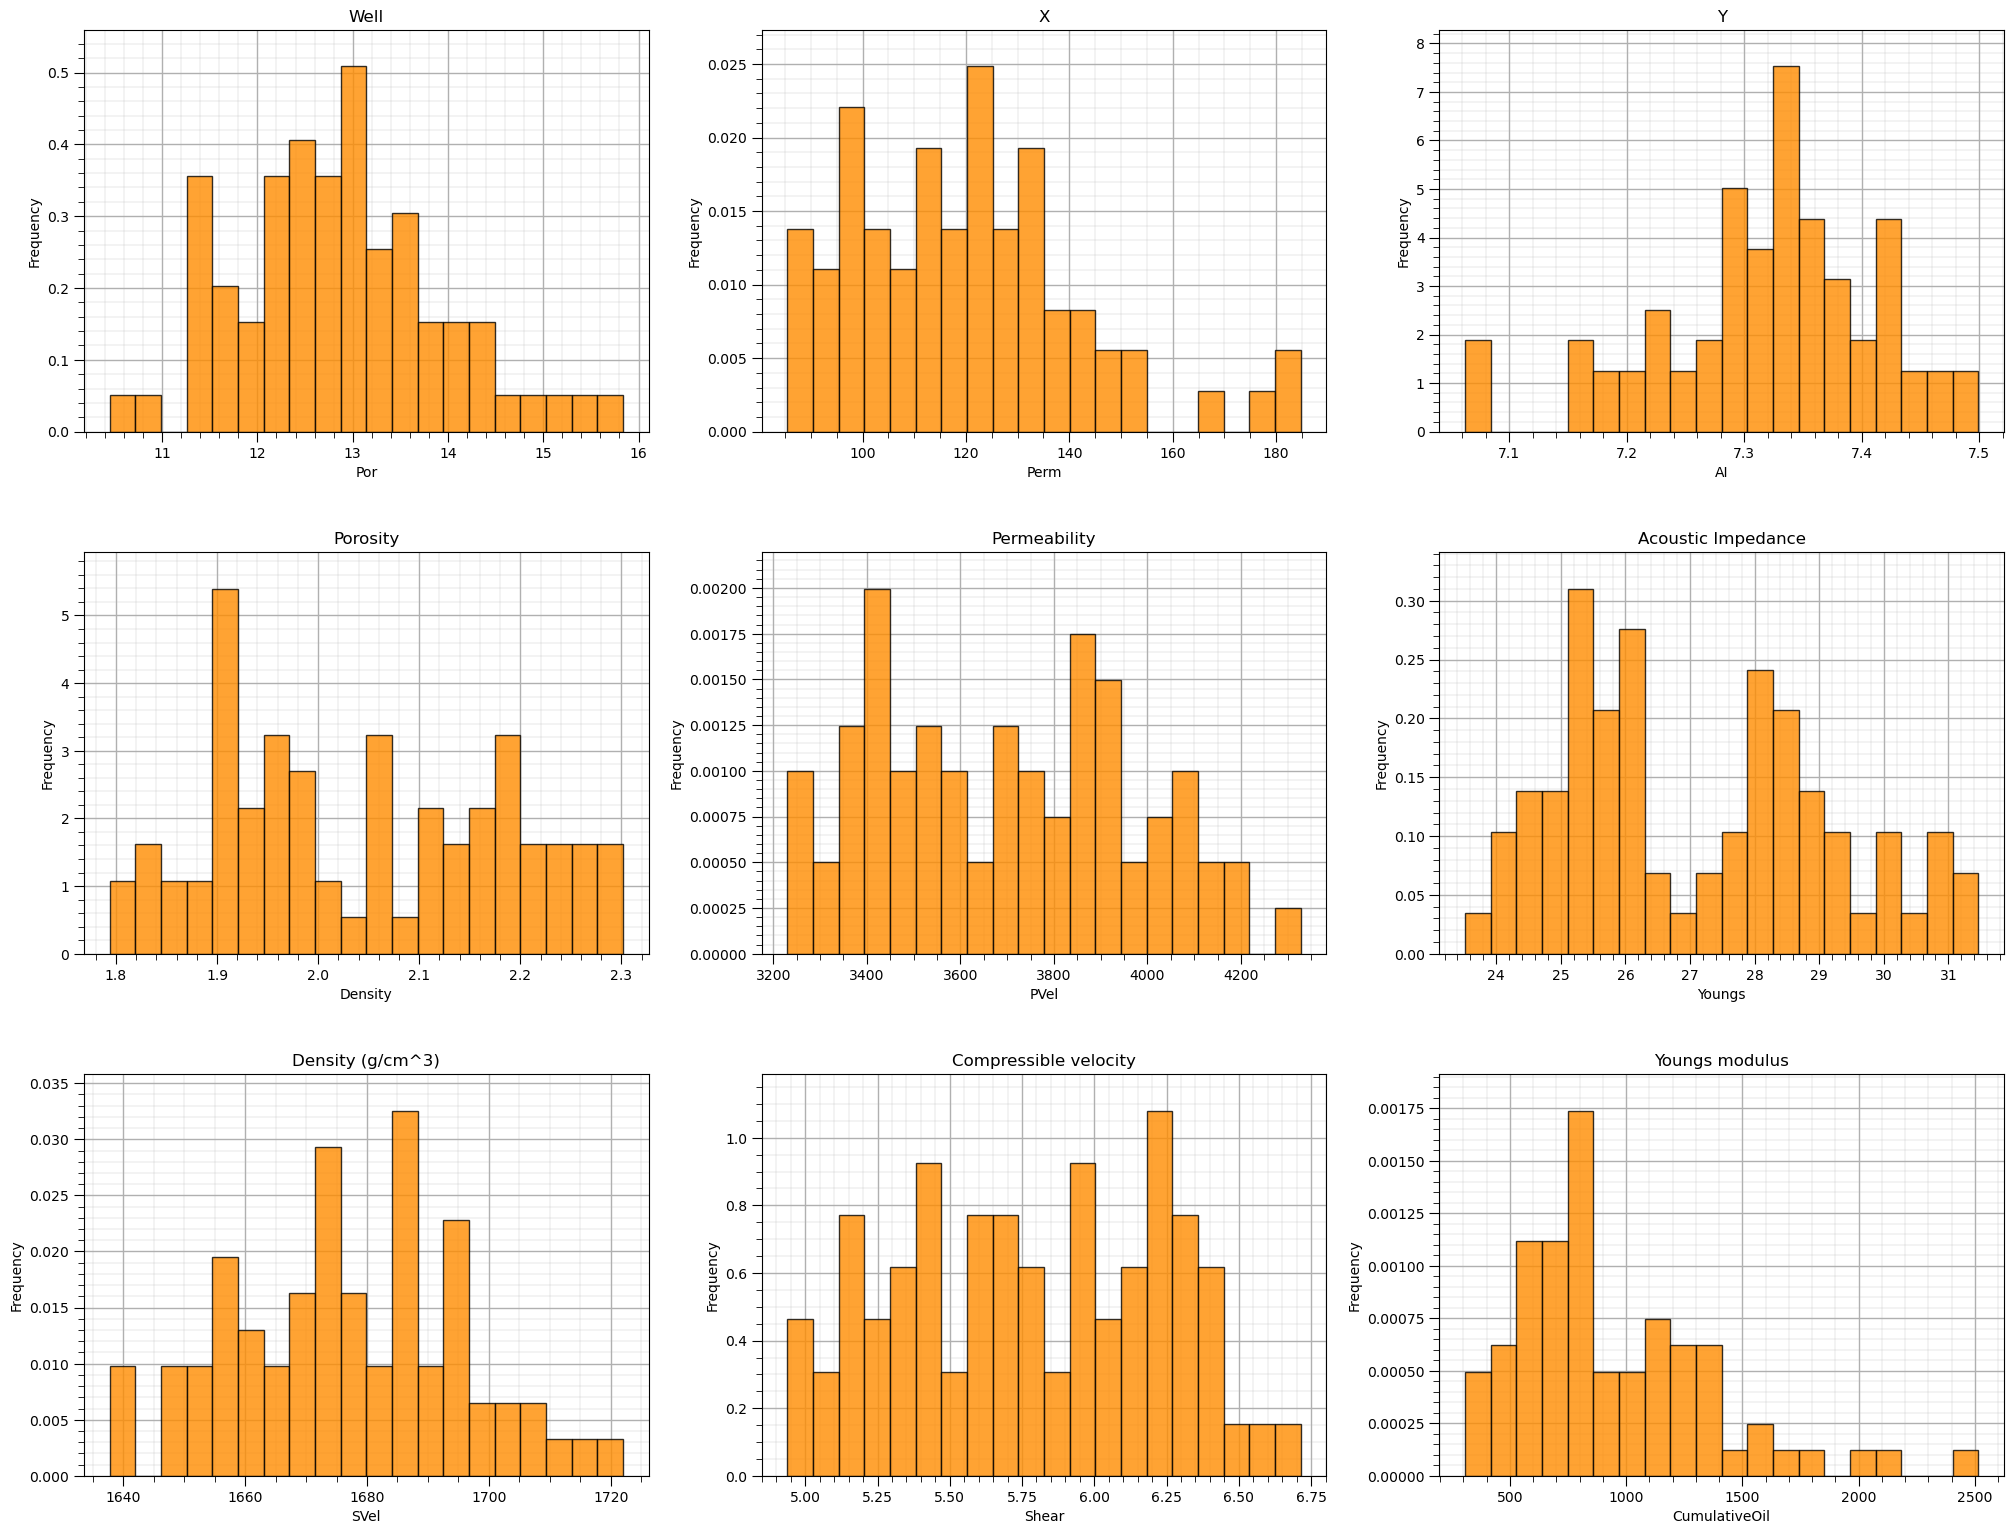

In [65]:
nbins = 20                                                    # number of histogram bins
for i, feature in enumerate(features):                        # plot histograms with central tendency and P10 and P90 labeled
    plt.subplot(4,3,i+1)
    y,_,_ = plt.hist(x=df[feature],weights=None,bins=nbins,alpha = 0.8,edgecolor='black',color='darkorange',density=True)
    # histogram_bounds(values=df[feature].values,weights=np.ones(len(df)),color='red')
    plt.xlabel(feature); plt.ylabel('Frequency'); plt.ylim([0.0,y.max()*1.10]); plt.title(featuretitle[i]); add_grid() 
    # if feature == resp:   
    #     plt.xlim([Ymin,Ymax])    
    # else:
    #     plt.xlim([xmin[i],xmax[i]]) 

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=4.1, wspace=0.2, hspace=0.3); plt.show()

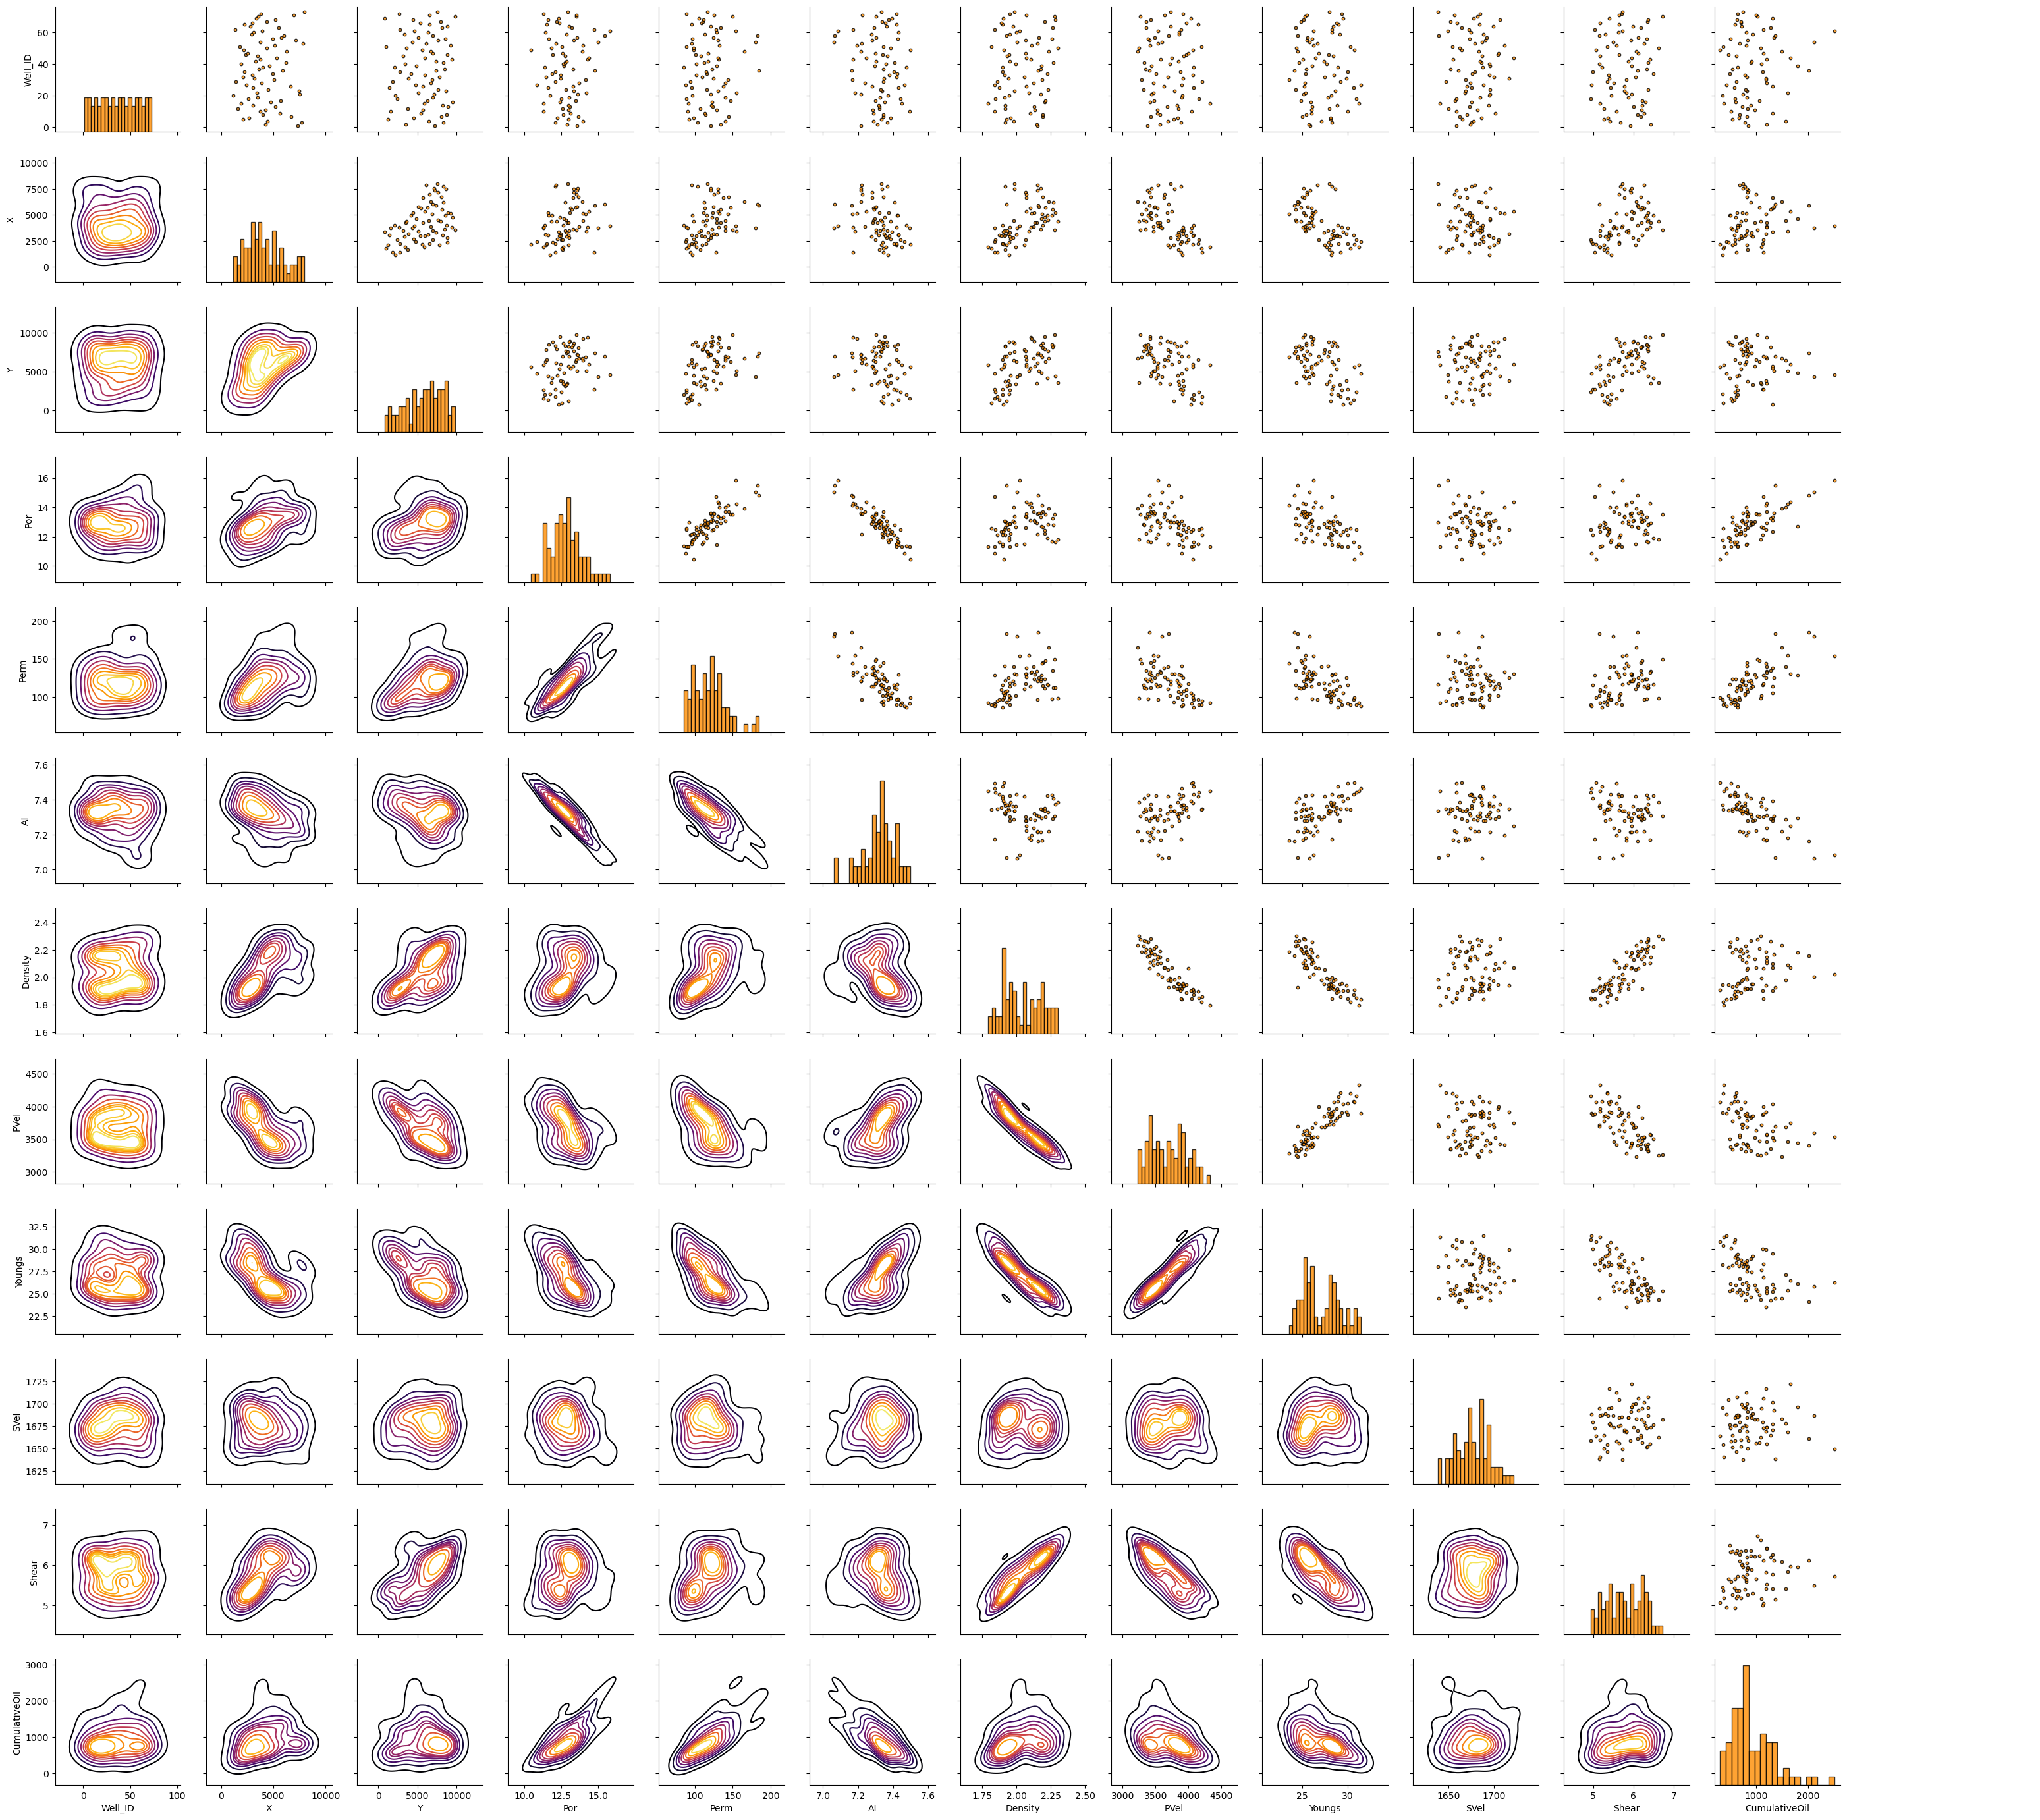

In [66]:
pairgrid = sns.PairGrid(df) # matrix scatter plots
pairgrid = pairgrid.map_upper(plt.scatter, color = 'darkorange', edgecolor = 'black', alpha = 0.8, s = 10)
pairgrid = pairgrid.map_diag(plt.hist, bins = 20, color = 'darkorange',alpha = 0.8, edgecolor = 'k')# Map a density plot to the lower triangle
pairgrid = pairgrid.map_lower(sns.kdeplot, cmap = plt.cm.inferno, 
                              shade = False, shade_lowest = False, alpha = 1.0, n_levels = 10)
pairgrid.add_legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.2); plt.show()

In [67]:
covariance = df.iloc[:,df.columns.get_indexer(features)].cov().iloc[len(features)-1,:len(features)] # calculate covariance matrix and slice for only pred - resp
cov_matrix = df.iloc[:,df.columns.get_indexer(features)].cov()
correlation = df.iloc[:,df.columns.get_indexer(features)].corr().iloc[len(features)-1,:len(features)] # calculate covariance matrix and slice for only pred - resp
corr_matrix = df.iloc[:,df.columns.get_indexer(features)].corr()
rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,df.columns.get_indexer(features)]) # calculate the rank correlation coefficient
rank_matrix = pd.DataFrame(rank_correlation,columns=corr_matrix.columns)
rank_correlation = rank_correlation[:,len(features)-1][:len(features)]
rank_correlation_pval = rank_correlation_pval[:,len(pred)-1][:len(features)]
                                           # plot correlation matrix with significance colormap
diff = corr_matrix.values - rank_matrix.values
diff_matrix = pd.DataFrame(diff,columns=corr_matrix.columns)
corr_diff = correlation - rank_correlation
partial_correlation = partial_corr(df.iloc[:,df.columns.get_indexer(features)]) # calculate the partial correlation coefficients
partial_matrix = pd.DataFrame(partial_correlation,columns=corr_matrix.columns)
partial_correlation = partial_correlation[:,len(features)-1][:len(features)]
semipartial_correlation = semipartial_corr(df.iloc[:,df.columns.get_indexer(features)])    # calculate the semi-partial correlation coefficients
semipartial_matrix = pd.DataFrame(semipartial_correlation,columns=corr_matrix.columns)
semipartial_correlation = semipartial_correlation[:,len(features)-1][:len(features)]  


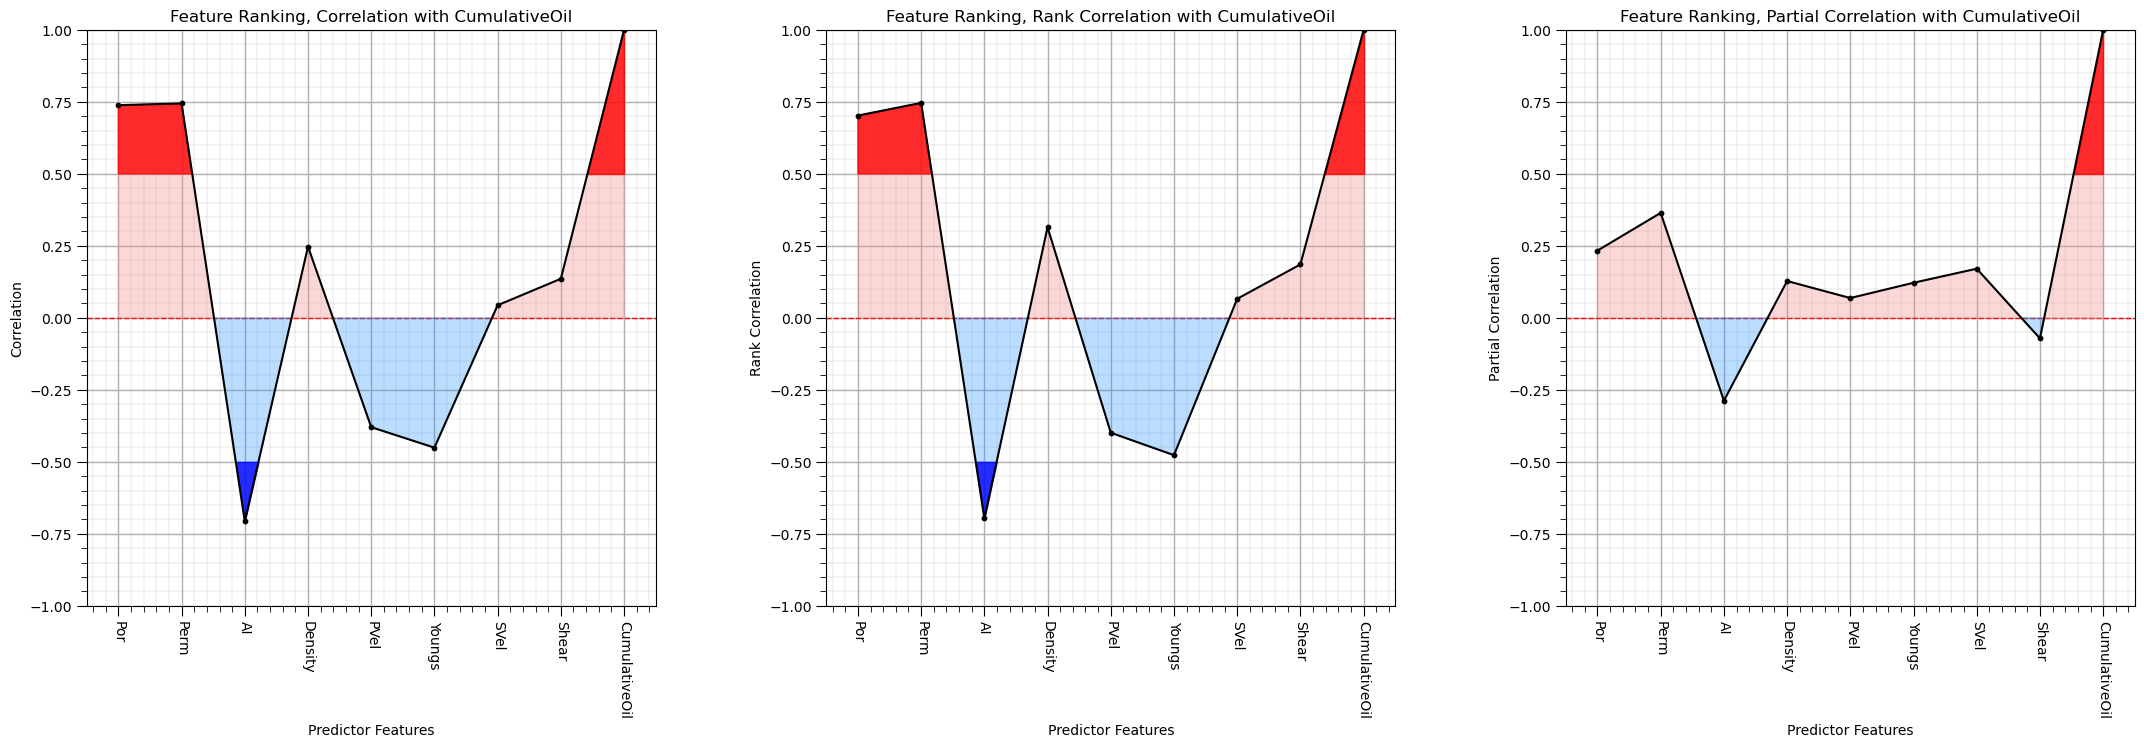

In [68]:
# plt.subplot(151)
# feature_rank_plot(features,covariance,-5000.0,5000.0,0.0,'Feature Ranking, Covariance with ' + resp,'Covariance',0.1)

plt.subplot(131)
feature_rank_plot(features,correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation',0.5)

plt.subplot(132)
feature_rank_plot(features,rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation',0.5)

plt.subplot(133)
feature_rank_plot(features,partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation',0.5)

# plt.subplot(155)
# feature_rank_plot(features,semipartial_correlation,-1.0,1.0,0.0,'Feature Ranking, Semipartial Correlation with ' + resp,'Semipartial Correlation',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.3, hspace=0.2); plt.show()

In [69]:
dfS = pd.DataFrame()                                          # Gaussian transform, standardization to a mean of 0 and variance of 1 

for feature in features:
    dfS[feature],d1,d2 = geostats.nscore(df,feature)

dfS.head()

stand_covariance = dfS.iloc[:,dfS.columns.get_indexer(features)].cov().iloc[len(features)-1,:len(features)]
stand_correlation = dfS.iloc[:,dfS.columns.get_indexer(features)].corr().iloc[len(features)-1,:len(features)]

stand_rank_correlation, stand_rank_correlation_pval = stats.spearmanr(dfS.iloc[:,dfS.columns.get_indexer(features)])
stand_rank_correlation = stand_rank_correlation[:,len(features)-1][:len(features)]
stand_partial_correlation = partial_corr(dfS.iloc[:,dfS.columns.get_indexer(features)]) # calculate the partial correlation coefficients
stand_partial_correlation = stand_partial_correlation[:,len(features)-1][:len(features)]
stand_semipartial_correlation = semipartial_corr(dfS.iloc[:,dfS.columns.get_indexer(features)])    # calculate the semi-partial correlation coefficients
stand_semipartial_correlation = stand_semipartial_correlation[:,len(features)-1][:len(features)] 

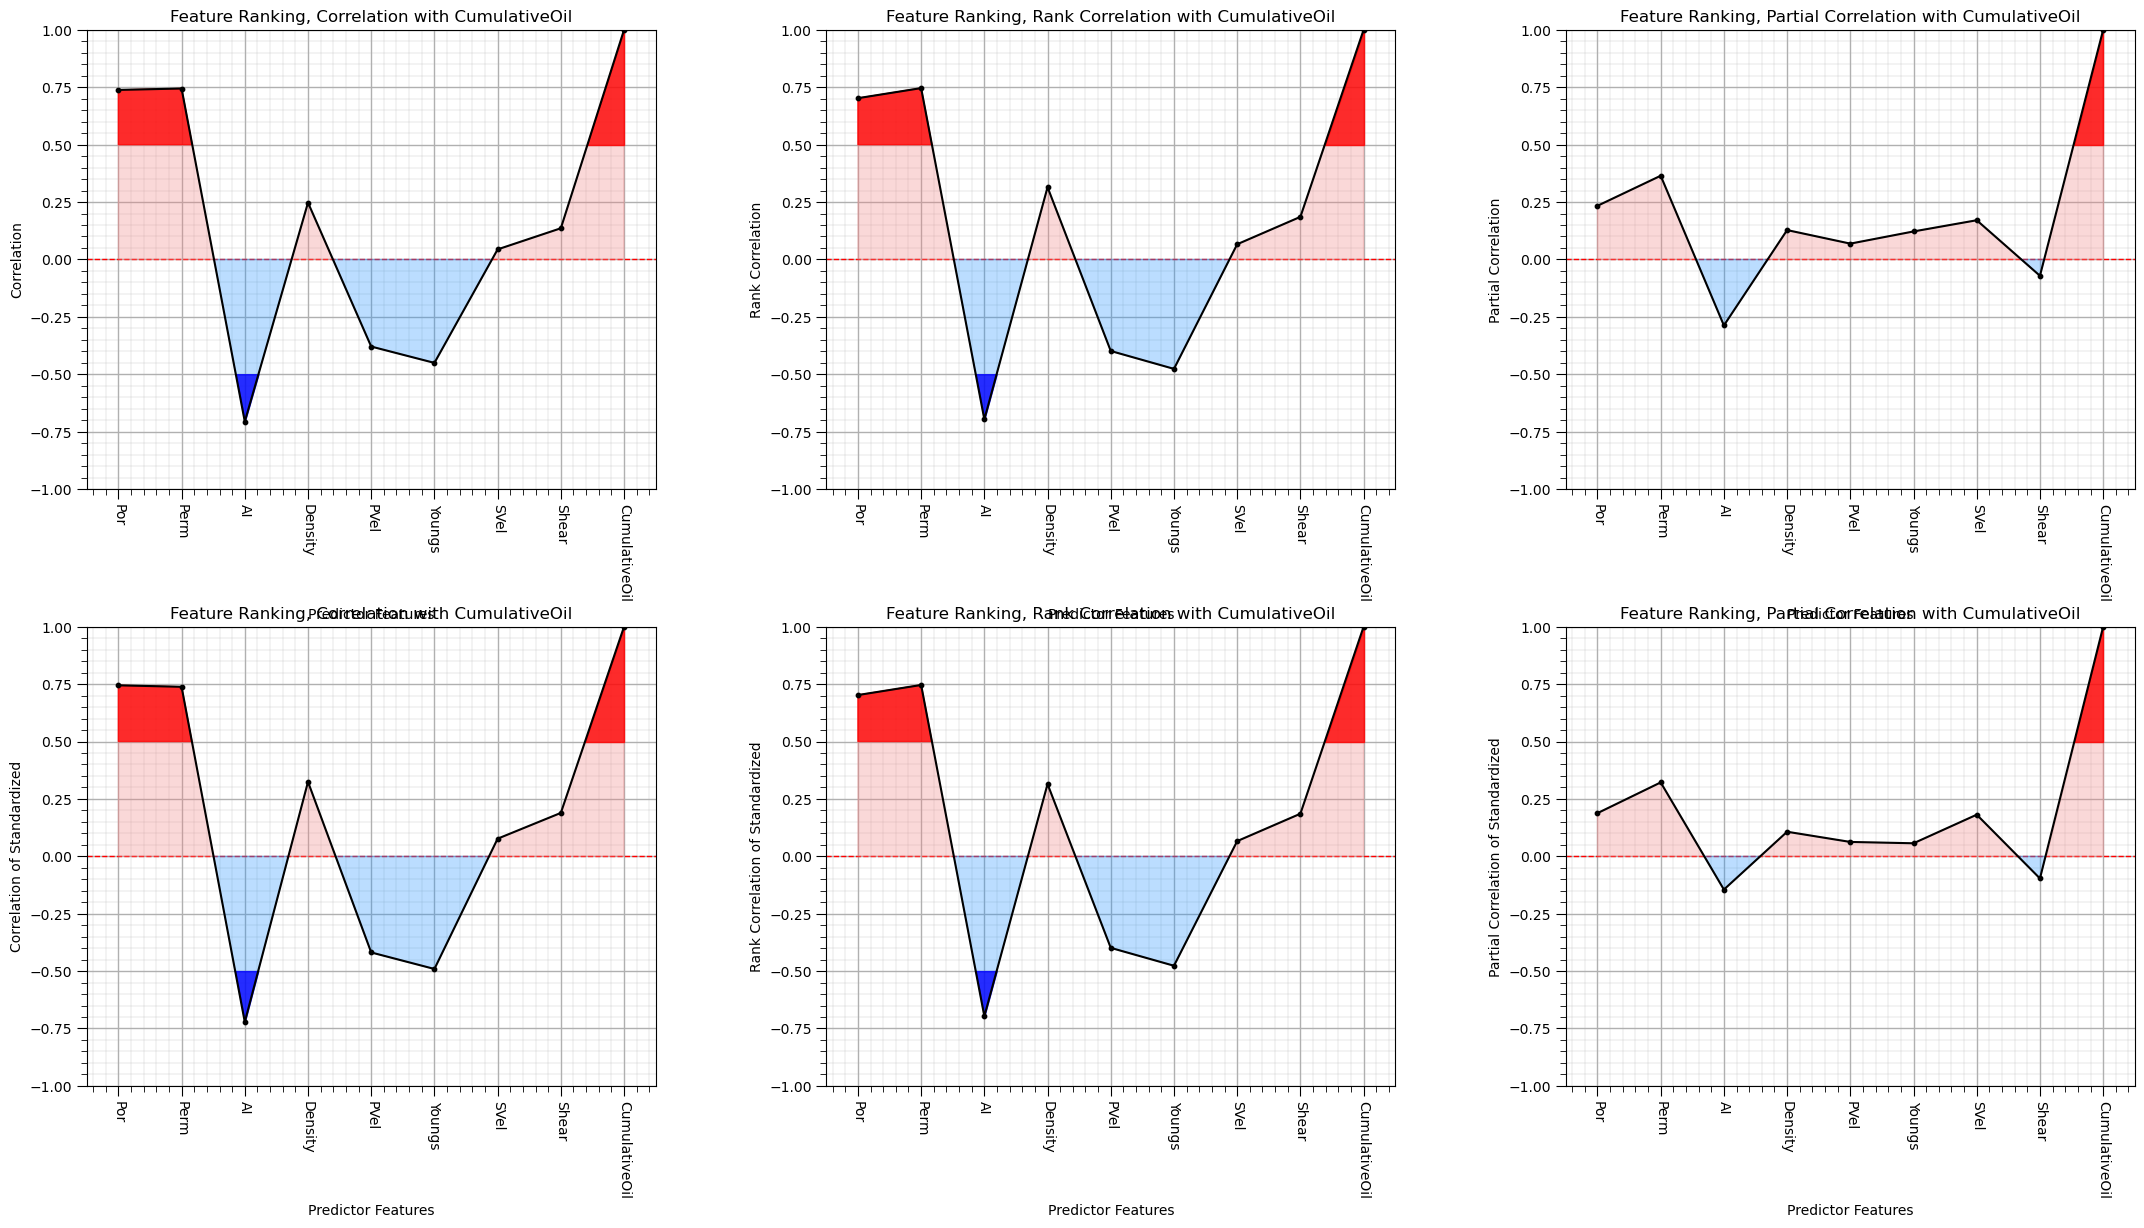

In [70]:
# plt.subplot(2,5,1)
# feature_rank_plot(features,covariance,-5000.0,5000.0,0.0,'Feature Ranking, Covariance with ' + resp,'Covariance',0.5)

plt.subplot(2,3,1)
feature_rank_plot(features,correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation',0.5)

plt.subplot(2,3,2)
feature_rank_plot(features,rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation',0.5)

plt.subplot(2,3,3)
feature_rank_plot(features,partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation',0.5)

# plt.subplot(2,5,5)
# feature_rank_plot(features,semipartial_correlation,-1.0,1.0,0.0,'Feature Ranking, Semipartial Correlation with ' + resp,'Semipartial Correlation',0.5)

# plt.subplot(2,5,6)
# feature_rank_plot(features,stand_covariance,-1.0,1.0,0.0,'Feature Ranking, Covariance with ' + resp,'Covariance of Standardized',0.5)

plt.subplot(2,3,4)
feature_rank_plot(features,stand_correlation,-1.0,1.0,0.0,'Feature Ranking, Correlation with ' + resp,'Correlation of Standardized',0.5)

plt.subplot(2,3,5)
feature_rank_plot(features,stand_rank_correlation,-1.0,1.0,0.0,'Feature Ranking, Rank Correlation with ' + resp,'Rank Correlation of Standardized',0.5)

plt.subplot(2,3,6)
feature_rank_plot(features,stand_partial_correlation,-1.0,1.0,0.0,'Feature Ranking, Partial Correlation with ' + resp,'Partial Correlation of Standardized',0.5)

# plt.subplot(2,5,10)
# feature_rank_plot(features,stand_semipartial_correlation,-1.0,1.0,0.0,'Feature Ranking, Semipartial Correlation with ' + resp,'Semipartial Correlation of Standardized',0.5)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.2, wspace=0.3, hspace=0.3); plt.show()



### What Each Graph Shows

1. **Correlation with Response (Correlation)**
   - **What it is:** Measures the linear relationship between each predictor and the response variable.
   - **Interpretation:** Values close to +1 or -1 indicate strong positive or negative linear relationships, respectively.

2. **Rank Correlation with Response (Spearman Rank Correlation)**
   - **What it is:** Measures the monotonic relationship (not just linear) between each predictor and the response, using ranks.
   - **Interpretation:** Like correlation, but less sensitive to outliers and non-linear relationships.

3. **Partial Correlation with Response**
   - **What it is:** Measures the linear relationship between each predictor and the response, **controlling for all other predictors**.
   - **Interpretation:** Shows the unique contribution of each feature, removing effects of other variables.

4. **Correlation of Standardized Features**
   - **What it is:** Same as (1), but after transforming all features to have mean 0 and variance 1 (standardization).
   - **Interpretation:** Removes scale effects, but for correlation, the ranking usually doesn’t change.

5. **Rank Correlation of Standardized Features**
   - **What it is:** Same as (2), but on standardized features.
   - **Interpretation:** Standardization doesn’t affect ranks, so this should look almost identical to (2).

6. **Partial Correlation of Standardized Features**
   - **What it is:** Same as (3), but on standardized features.
   - **Interpretation:** Standardization can affect partial correlations if variables had very different scales, but often the ranking is similar.

---

### Why Four Graphs Look the Same

- **Correlation, Rank Correlation, and their standardized versions** (plots 1, 2, 4, 5) look very similar because:
  - data is already well-behaved (no extreme outliers, no strong non-linearities).
  - Standardization does not change the order or relationship for correlation and rank correlation.
  - The relationships between predictors and response are mostly linear and monotonic.

---

### What This Similarity Means

- **Consistency:** The fact that these metrics agree suggests feature rankings are robust—your most important features will be the same no matter which of these basic metrics you use.
- **Data Quality:** There are no strong outliers or non-linearities distorting the results.
- **Interpretation:** confident that the features identified as most important (highest or lowest bars) are truly the most relevant for predicting your response variable.

---

**Summary:**  
When multiple feature ranking metrics agree, it means your data is clean, relationships are mostly linear, and your feature importance results are stable and reliable. This gives confidence in selecting features for your predictive models.



**Third Cut**
Using differnt models of prediction and cross anaylising as well as testing differnt features.
1st, random forest regressor

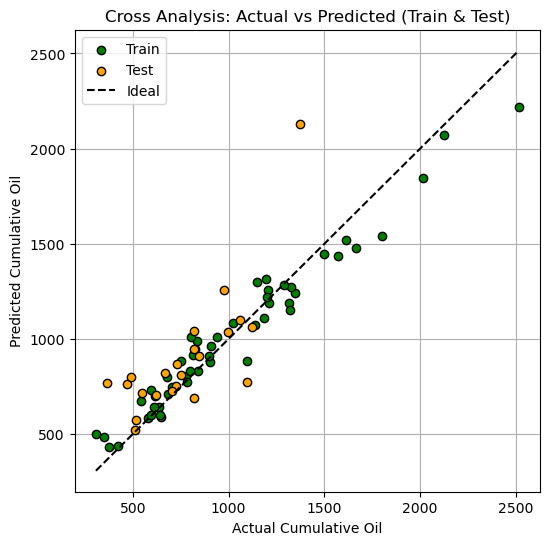

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
class OilProductionModel:
    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    def train_model(self, X, y):
        self.model.fit(X, y)
        # Optionally return training score or cross-validation
        return self.model.score(X, y)
    
    def predict(self, X):
        return self.model.predict(X)



# Load training (cleaned) data
full_df = pd.read_csv('/workspaces/hackathon-VictoriaAfnani/Pyrcz_ebook/dataframe_imputed.csv')
train_df, test_df = train_test_split(full_df, test_size=0.3, random_state=42)
X_train = train_df.drop(columns=['Well_ID', 'CumulativeOil','Density', 'PVel', 'SVel', 'Shear', 'X', 'Y'])
y_train = train_df['CumulativeOil']
X_test = test_df.drop(columns=['Well_ID', 'CumulativeOil','Density', 'PVel', 'SVel', 'Shear', 'X', 'Y'])
y_test = test_df['CumulativeOil']

# Train the model
model = OilProductionModel()
model.train_model(X_train, y_train)

# Load test wells data


# Prepare test features (drop Well_ID if present, and any columns not in training)


# Predict CumulativeOil for test wells
train_df['Predicted_CumulativeOil'] = model.predict(X_train)
test_df['Predicted_CumulativeOil'] = model.predict(X_test)

plt.figure(figsize=(6,6))
# Plot training data (green)
plt.scatter(y_train, train_df['Predicted_CumulativeOil'], color='green', edgecolor='k', label='Train')
# Plot test data (orange)
plt.scatter(y_test, test_df['Predicted_CumulativeOil'], color='orange', edgecolor='k', label='Test')
# Ideal line
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         'k--', label='Ideal')
plt.xlabel('Actual Cumulative Oil')
plt.ylabel('Predicted Cumulative Oil')
plt.title('Cross Analysis: Actual vs Predicted (Train & Test)')
plt.legend()
plt.grid(True)
plt.show()

# Plot predictions on a map (X vs Y, colored by predicted oil)
#plt.figure(figsize=(8,6))
#sc = plt.scatter(test_df['X'], test_df['Y'], c=test_df['Predicted_CumulativeOil'], cmap='viridis', s=100, edgecolor='k')
#plt.colorbar(sc, label='Predicted Cumulative Oil')
#plt.xlabel('X Coordinate')
#plt.ylabel('Y Coordinate')
#plt.title('Predicted Cumulative Oil for Test Wells')
#plt.grid(True)
#plt.show()

In [100]:
import pandas as pd

# Load the 10 new wells test file
df_test = pd.read_csv('/workspaces/hackathon-VictoriaAfnani/problem/res21_2D_wells_test_imputed.csv')

# Drop columns not used by the model
columns_to_drop = ['Well_ID', 'CumulativeOil','Density', 'PVel', 'SVel', 'Shear', 'X', 'Y']
df_test_model = df_test.drop(columns=columns_to_drop, errors='ignore')

# Use the same features as your KNN model
selected_predictor_features = ['Por', 'Perm', 'AI']

# Impute and normalize using the same objects as your KNN pipeline
X_new = df_test_model[selected_predictor_features]
X_new_imputed = mice_imputer.transform(X_new)
X_new_imputed = pd.DataFrame(X_new_imputed, columns=X_new.columns, index=X_new.index)
X_new_imputed_norm = normalizer.transform(X_new_imputed)
X_new_imputed_norm = pd.DataFrame(X_new_imputed_norm, columns=X_new_imputed.columns, index=X_new_imputed.index)

# Predict with your trained KNN model
y_new_pred = knn_model.predict(X_new_imputed_norm)
df_test['Predicted_CumulativeOil'] = y_new_pred

# Save for plotting
new_df = df_test

new_df

Well_ID       X       Y        Por        Perm        AI   Density  \
0       74  7925.0  5525.0  12.297556  138.797065  7.386720  2.113875   
1       75  8125.0  4425.0  13.370750   71.992542  7.393464  1.954353   
2       76  7725.0  4625.0  13.390333  195.267385  7.246248  2.079348   
3       77  6825.0  4475.0  13.870105  128.974715  7.254626  2.157615   
4       78  7425.0  3975.0  13.351167  151.252341  7.291226  1.927381   
5       79  6875.0  4125.0  14.588533  140.113528  7.194660  1.887621   
6       80  7525.0  4925.0  12.495294   82.326745  7.355745  2.266880   
7       81  9025.0  4825.0  12.234105  117.458572  7.390554  1.862495   
8       82  6025.0  4425.0  12.278895  126.921596  7.312159  2.195301   
9       83  6375.0  3725.0  12.073750  127.838824  7.224643  1.912184   

          PVel     Youngs         SVel     Shear  Predicted_CumulativeOil  
0  3497.399163  25.438942  1641.413329  6.302022               763.512333  
1  3911.754285  26.721135  1644.080134  5.819129               718.228667  
2  3592.473231  28.003328  1658.458824  5.819129              1182.324333  
3  3526.262903  24.569174  1666.223529  6.311062              1073.589000  
4  3695.171078  28.761366  1705.296805  5.345275              1013.266333  
5  3847.731545  29.519405  1685.760167  5.454473              1169.316333  
6  3331.845076  26.721135  1660.546761  6.292982               735.274000  
7  4206.389963  26.721135  1625.705857  5.476935               734.984000  
8  3304.759974  24.742882  1694.248092  6.333516               821.822333  
9  3842.945020  29.529052  1680.235811  5.492577               878.595000

Knn model

In [74]:
import numpy as np                                            # arrays
import pandas as pd                                           # dataframes
import matplotlib.pyplot as plt                               # plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, AutoLocator) # control of axes ticks
from sklearn.experimental import enable_iterative_imputer     # required for MICE imputation
from sklearn.impute import IterativeImputer                   # MICE imputation
from sklearn.model_selection import train_test_split          # train and test split
from sklearn.linear_model import LinearRegression             # linear regression
from sklearn.preprocessing import StandardScaler              # standardize the features
from sklearn.preprocessing import MinMaxScaler                # min and max normalization
from sklearn.neighbors import KNeighborsRegressor             # K-nearest neighbours
from sklearn import tree                                      # decision tree
from sklearn import metrics                                   # measures to check our models
plt.rc('axes', axisbelow=True)                                # set axes and grids in the background for all plots
import math                                                  
seed = 13

def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

In [75]:
df = pd.read_csv(r"/workspaces/hackathon-VictoriaAfnani/Pyrcz_ebook/dataframe_imputed.csv") # load the data from my github repo
df.head()  

Well_ID       X       Y        Por        Perm        AI   Density  \
0        1  7325.0  7175.0  13.564033  120.883052  7.214987  2.153530   
1        2  4225.0  3525.0  12.907730  133.910637  7.308846  2.146360   
2        3  7725.0  8275.0  12.110566  104.059282  7.366451  1.919698   
3        4  4425.0  6475.0  13.990654  139.915993  7.286771  1.980721   
4        5  2125.0  1225.0  12.982720   92.421183  7.333877  1.928716   

          PVel     Youngs         SVel     Shear  CumulativeOil  
0  3379.255305  25.875998  1658.612455  5.917793         847.33  
1  3563.549461  25.688560  1673.770439  6.429229        1201.20  
2  3882.442911  28.312217  1675.645601  5.674798         781.40  
3  3688.351168  27.125611  1677.779759  5.408664        1573.20  
4  3777.566423  28.133694  1664.941701  5.265054         548.68

In [76]:
selected_predictor_features = ['Por','Perm','AI'] # set the selected predictor features
response_feature = ['CumulativeOil']                             # set the response feature
features = selected_predictor_features + response_feature     # build a list of selected predictor and response features
df_selected = df.loc[:,features]                              # slice the DataFrame
df_selected.head()

Por        Perm        AI  CumulativeOil
0  13.564033  120.883052  7.214987         847.33
1  12.907730  133.910637  7.308846        1201.20
2  12.110566  104.059282  7.366451         781.40
3  13.990654  139.915993  7.286771        1573.20
4  12.982720   92.421183  7.333877         548.68

In [77]:


X = df_selected.loc[:,selected_predictor_features]            # slice a X, predictor 
y = df_selected.loc[:,response_feature]
print('Predictor Features: ' + str(X.columns))
print('Response Feature: ' + str(y.columns))

mice_imputer = IterativeImputer(random_state = seed)          # instantiate Multiple Imputation by Chained Equations (MICE) imputer
X_imputed = mice_imputer.fit_transform(X)                     # train and apply MICE to impute the missing data
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=X.index) # make imputed results into a DataFrame with same columns as X
X_imputed.describe()        

normalizer = MinMaxScaler()                                   # instantiate min / max normalizer  
norm_array = normalizer.fit_transform(X_imputed)              # normalize the predictor features                 
X_imputed_norm = pd.DataFrame(norm_array, columns=X_imputed.columns) # convert output to a DataFrame
X_imputed_norm.describe()     


Predictor Features: Index(['Por', 'Perm', 'AI'], dtype='object')
Response Feature: Index(['CumulativeOil'], dtype='object')


Por       Perm         AI
count  73.000000  73.000000  73.000000
mean    0.445829   0.345424   0.589667
std     0.199253   0.227433   0.218757
min     0.000000   0.000000   0.000000
25%     0.311485   0.164795   0.499428
50%     0.444114   0.323058   0.622574
75%     0.572130   0.454171   0.725487
max     1.000000   1.000000   1.000000

In [78]:
scaler = StandardScaler()                                     # instantiate standardizer  
standard_array = scaler.fit_transform(X_imputed)              # standardize the predictor features    
X_imputed_stand = pd.DataFrame(standard_array, columns=X_imputed.columns) # convert output to a DataFrame
X_imputed_stand.describe()   

test_proportion = 0.2                                         # set the proportion of withheld testing data
X_imputed_norm_train, X_imputed_norm_test, y_train, y_test = train_test_split(X_imputed_norm, y, test_size=test_proportion, random_state=seed) # train and test split

In [79]:
n_neighbours = 20; p = 2; weights = 'uniform'                 # model hyperparameters
neigh = KNeighborsRegressor(weights = weights,n_neighbors=n_neighbours,p = p) # instantiate the prediction model
neigh_fit = neigh.fit(X_imputed_norm_train,y_train)           # train the model with the training data

In [80]:
k = 1; weights = 'uniform'                                    # set initial, lowest k hyperparameter
MSE_knn_list = []; k_list = []                                    # make lists to store the results
while k <= 30:                                               # loop over the k hyperparameter
    knn_model = KNeighborsRegressor(weights = weights, n_neighbors=k, p = 2).fit(X_imputed_norm_train,y_train) # instandiate and train the model
    y_test_pred = knn_model.predict(X_imputed_norm_test)      # predict over the testing cases
    MSE = metrics.mean_squared_error(y_test,y_test_pred)      # calculate the MSE testing
    MSE_knn_list.append(MSE)                                      # add to the list of MSE
    k_list.append(k)                                          # append k to an array for plotting
    k = k + 1

In [81]:
leaf_node = 2                                                 # set initial hyperparameter
MSE_tree_list = []; leaf_node_list = []                       # make lists to store the results
while leaf_node <= 16:                                        # loop over the number of leaf nodes hyperparameter
    tree_model = tree.DecisionTreeRegressor(max_leaf_nodes=leaf_node).fit(X_imputed_norm_train,y_train) # instandiate and train the model
    y_test_pred = tree_model.predict(X_imputed_norm_test)     # predict over the testing cases
    MSE_tree = metrics.mean_squared_error(y_test,y_test_pred) # calculate the MSE testing
    MSE_tree_list.append(MSE_tree)                            # add to the list of MSE
    leaf_node_list.append(leaf_node)                          # append leaf node to an array for plotting
    leaf_node = leaf_node + 1

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=4.0, wspace=0.2, hspace=0.2); plt.show()

<Figure size 640x480 with 0 Axes>

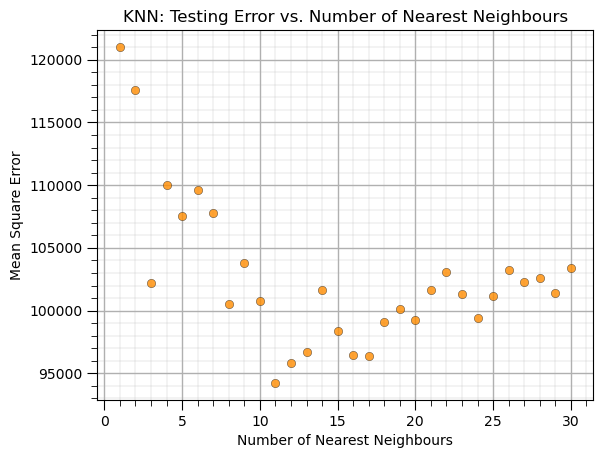

In [82]:
plt.subplot(111)
plt.scatter(k_list,MSE_knn_list,s=None, c='darkorange', alpha=0.8, linewidths=0.3, edgecolors="black") # scatter plot testing MSE vs. hyperparameter
plt.title('KNN: Testing Error vs. Number of Nearest Neighbours'); plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error'); add_grid()

In [83]:
tuned_k = k_list[np.argmin(MSE_knn_list)]                         # get the k that minimizes the testing MSE
print('Tuned K is : ' + str(tuned_k))

Tuned K is : 11


In [84]:
knn_tuned_model = KNeighborsRegressor(weights = weights, n_neighbors=tuned_k, p = 2).fit(X_imputed_norm,y) # retrain the tuned model with all data

In [98]:
df_new = pd.read_csv(r"/workspaces/hackathon-VictoriaAfnani/problem/res21_2D_wells_test_imputed.csv") # load the data from my github repoload the data from my github repo  
columns_to_drop = ['Well_ID', 'CumulativeOil','Density', 'PVel', 'SVel', 'Shear', 'X', 'Y']  # Replace with the columns you want to drop
df_new = df_new.drop(columns=columns_to_drop, errors='ignore')
                   # in actual use, we would not have the truth, so removing it here
X_new = df_new.loc[:,selected_predictor_features]             # select the predictor features
X_new_imputed = mice_imputer.fit_transform(X_new)             # impute the missing data
X_new_imputed = pd.DataFrame(X_new_imputed, columns=X_new.columns, index=X_new.index) # make imputed results into a DataFrame
X_new_imputed_norm = normalizer.fit_transform(X_new_imputed)  # normalize the predictor featurs
X_new_imputed_norm = pd.DataFrame(X_new_imputed_norm, columns=X_new_imputed.columns)
X_new_imputed_norm.head()          

Por      Perm        AI
0  0.088996  0.541915  0.966077
1  0.515750  0.000000  1.000000
2  0.523537  1.000000  0.259493
3  0.714318  0.462237  0.301633
4  0.507963  0.642952  0.485736

In [99]:
y_new_pred = knn_model.predict(X_new_imputed_norm)            # predict over the testing cases
df_new['Predictions'] = y_new_pred
df_new

Por        Perm        AI     Youngs  Predictions
0  12.297556  138.797065  7.386720  25.438942   763.512333
1  13.370750   71.992542  7.393464  26.721135   718.228667
2  13.390333  195.267385  7.246248  28.003328  1182.324333
3  13.870105  128.974715  7.254626  24.569174  1073.589000
4  13.351167  151.252341  7.291226  28.761366  1013.266333
5  14.588533  140.113528  7.194660  29.519405  1169.316333
6  12.495294   82.326745  7.355745  26.721135   735.274000
7  12.234105  117.458572  7.390554  26.721135   734.984000
8  12.278895  126.921596  7.312159  24.742882   821.822333
9  12.073750  127.838824  7.224643  29.529052   878.595000